# DAILY READOUT TASK -- Purpose in Industry

A **daily read-out** is a short, decision-driving artifact that summarizes yesterday’s data for an experiment or live-ops feature.

It’s not a 20-page report—it’s usually **1–2 pages or a tight dashboard view**.

The key **audience is a non-technical PM or designer who wants:**

Did the treatment outperform control?

Are any “guardrail” metrics (retention, crashes, revenue) harmed?

What’s the binary decision (ship / hold / rollback)?


=====================================================================

# **Core Structure of a Daily Read-Out**

a. **Metrics Snapshot**

Primary metric: e.g., conversion rate, session length, DAU (daily active users).

Guardrails: metrics you monitor to ensure you didn’t break something (crash rate, churn, support tickets).

b. **Statistical Check**

Comparison of test vs control (t-test, proportion test, or Bayesian credible interval).

Effect size + uncertainty (e.g., +2.3% ± 0.7%).

c. **Visualization**

One clean plot (bar chart with error bars, line chart over time).

d. **Decision & Risks**

Final 2–3 sentences, e.g.:

“Decision: Rollout. Risk: small decrease in session length (p=0.08). Monitor over next 3 days.”



In [25]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

In [4]:
#load data
experiment = pd.read_csv('mock_ab_experiment.csv')

In [3]:
experiment.head()

,user_id,group,converted,session_length,revenue
0,1,control,0,30.888505,0.861138
1,2,control,1,23.323278,3.123327
2,3,control,0,31.900989,3.550755
3,4,control,0,33.052929,0.808586
4,5,control,0,32.798952,2.597003


In [6]:
#percentage of players converted
perc_conv = experiment['converted'].value_counts(normalize=True)
print(perc_conv)

converted
0    0.8845
1    0.1155
Name: proportion, dtype: float64


In [10]:
#average player spend to date
ARPU = experiment['revenue'].mean()
print(round(ARPU, 2))

4.24


In [11]:
#average session length to date
retention = experiment['session_length'].mean()
print(retention)

29.946020982591605


# Z-Proportions: Converted by test/control groups

In [36]:
#z-proportions test for control vs test groups - conversion (binary outcome)
#determine if the num of converted is same for test/control
converted_counts = experiment.groupby('group')['converted'].value_counts()
print(converted_counts)

group    converted
control  0            900
         1            100
test     0            869
         1            131
Name: count, dtype: int64


In [16]:
converted_array = np.array([100, 131])
totals_array = np.array([100 + 900, 131 + 869])

In [93]:
control_conv_perc = 100 / 1000 * 100
test_conv_perc = 131 / 1000 * 100 
print(f"Control: {round(control_conv_perc, 2)}%, Test: {round(test_conv_perc, 2)}%")

Control: 10.0%, Test: 13.1%


In [103]:
rel_uplift = (test_conv_perc - control_conv_perc) / control_conv_perc
print(f"{round(rel_uplift * 100, 2)}%")

31.0%


# Z-Test Result

In [19]:
z_score, p_value = proportions_ztest(count=converted_array, nobs=totals_array, alternative='two-sided')
print(z_score, p_value)

-2.1687364826622564 0.030102695927324397


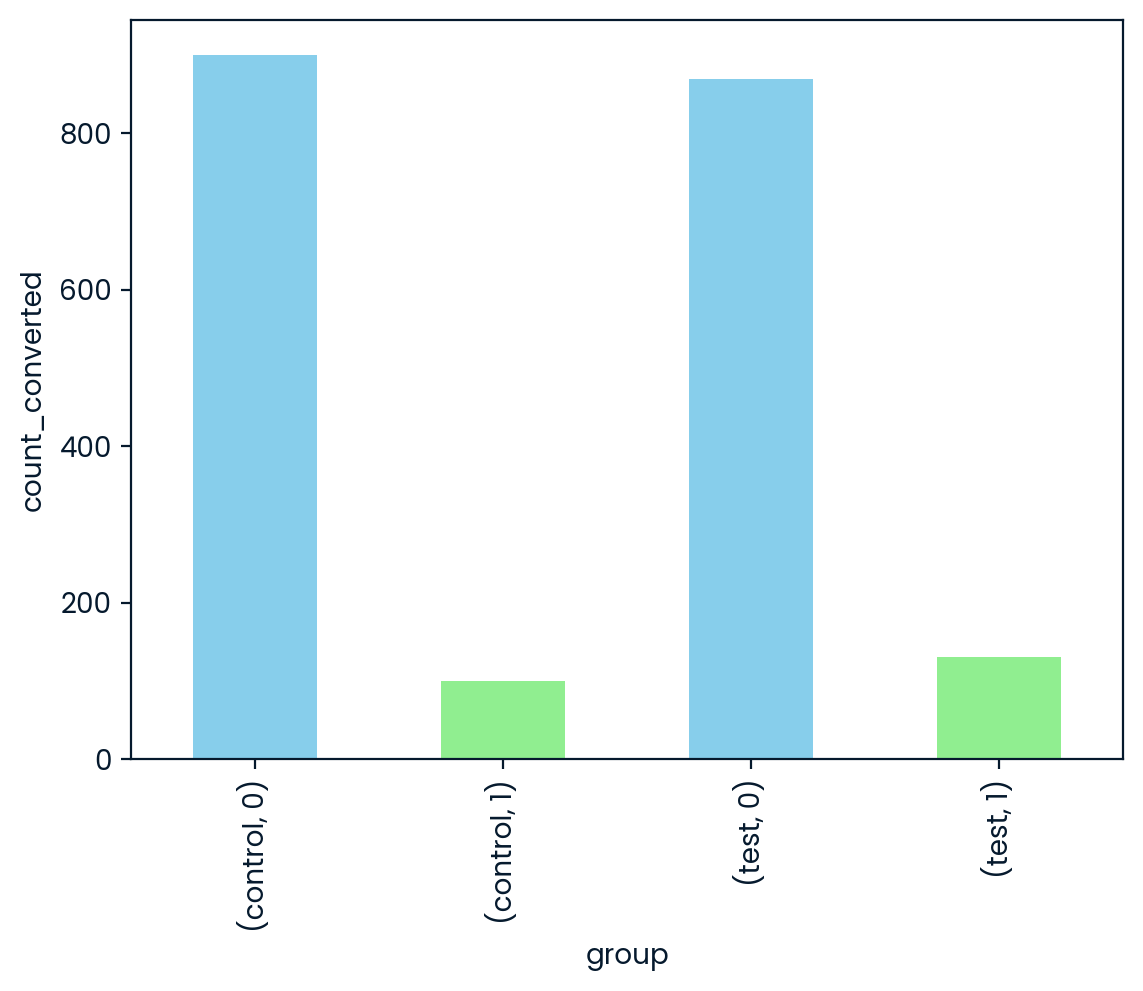

In [57]:
colors = ['lightgreen' if idx[1] == 1 else 'skyblue' for idx in converted_counts.index]
converted_counts.plot(kind='bar', color=colors)
plt.xlabel('group')
plt.ylabel('count_converted')
plt.show()

# T-test Session Length

In [22]:
avg_session_by_test_group = experiment.pivot_table(values='session_length', index='group', aggfunc='mean')
print(avg_session_by_test_group)

         session_length
group                  
control       30.494479
test          29.397563


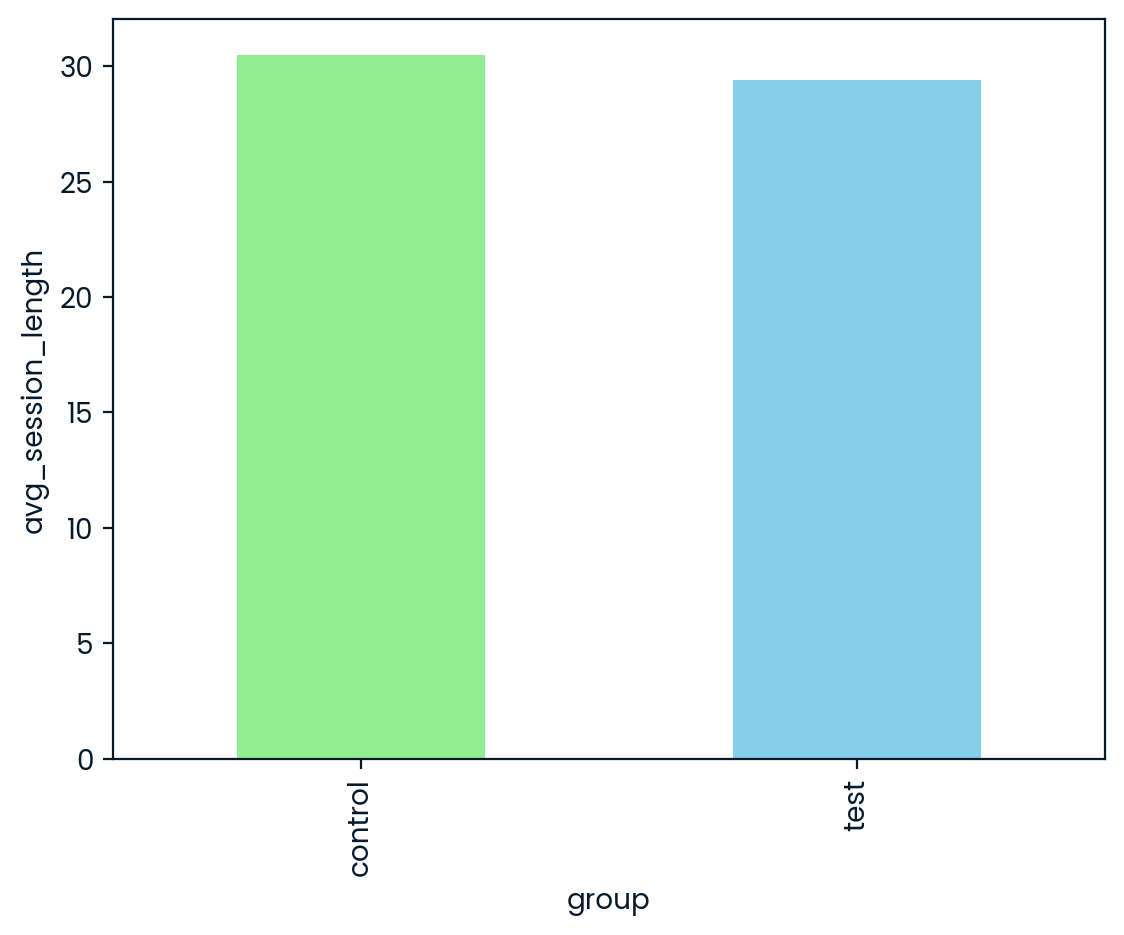

In [83]:
colors = ['lightgreen', 'skyblue']
ax = avg_session_by_test_group['session_length'].plot(kind='bar', color=colors)
ax.set_ylabel('avg_session_length')
plt.show()

In [95]:
control_sessions = experiment[experiment['group'] == 'control']['session_length']

In [96]:
test_sessions = experiment[experiment['group'] == 'test']['session_length']

# T-test Session - Result

In [32]:
t_stat_sess, p_val_sess = ttest_ind(control_sessions, test_sessions)
print(t_stat_sess, p_val_sess)

4.960168797857834 7.638582380856614e-07


# T-test Session Effect Size

In [90]:
def cohens_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()

    pooled_std = np.sqrt((n1 - 1) * var1 + (n2 - 1) * var2 / n1 + n2 - 2)

    d = diff / pooled_std

    return d

In [91]:
cohens_d_session = cohens_d(control_sessions, test_sessions)
print(cohens_d_session)

0.006876211605634635


In [99]:
print(control_sessions.std())
print(test_sessions.std())

4.94466515799705
4.945237047584502


# T-test Revenue

In [28]:
avg_spend_by_test_group = experiment.pivot_table(values='revenue', index='group', aggfunc='mean')
print(avg_spend_by_test_group)

          revenue
group            
control  4.064301
test     4.416106


In [30]:
control_revenue = experiment[experiment['group'] == 'control']['revenue']

In [29]:
test_revenue = experiment[experiment['group'] == 'control']['revenue']

# T-test Revenue - Result

In [34]:
t_stat_rev, p_val_rev = ttest_ind(control_revenue, test_revenue)
print(t_stat_rev, p_val_rev)

0.0 1.0


# Decision: Read-Out

**Conversion Rate:** Z-proportion test results in a significantly different conversion rate for the test group vs. the control group (z = -2.17, p < 0.05). Test group had a 13% conversion percentage out of the total sample, while the control group only had a 10% conversion percentage. This represents a 31% relative uplift in conversion for the test group, compared to the control group. 

**Session Length:** Test group shows a significant decrease in average session length from test group to control group by approximately -1 minute (control = 30.5, test = 29.4), however, the effect size is negligible (t = 4.9601, p < 0.05, d = .0068). This should be flagged to observe for more drastic changes if experiment is rolled out.

**Revenue:** Revenue test regarding average player spend between test and control groups returned insignficant results. 

**Decision:** The experiment was successful regarding conversions. There was a significant, negative impact on session length (approximately -1 min for the test group), however, given that average session length varies by +/- 5 min, this 1 minute difference is negligible. The average revenue spend between test and control groups did not show any significant difference. 